# Robot Painter

## Notebook Setup 
The following cell will install Drake, checkout the manipulation repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  

More details are available [here](http://manipulation.mit.edu/drake.html).

In [ ]:
import importlib
import os, sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='dc0eb8aa32e271d9b5299a84435694d0565346af', drake_version='20200909', drake_build='nightly')

In [ ]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt, mpld3
from IPython.display import HTML, display

# Setup pyngrok.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

# Let's do all of our imports here, too.
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph, AngleAxis, BasicVector, ConnectMeshcatVisualizer, MeshcatVisualizer,
    DiagramBuilder, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
    LeafSystem, MultibodyPlant, MultibodyPositionToGeometryPose, Parser, 
    PiecewisePolynomial, PiecewiseQuaternionSlerp, Quaternion, RigidTransform, 
    RollPitchYaw, RotationMatrix, SceneGraph, Simulator, TrajectorySource,
    AddTriad
)

In the following cell we provide a wrapper class that hides parts of the implementation details in Drake. You are not required to understand how it works.

In [ ]:
from pydrake.examples.manipulation_station import ManipulationStation
class IIWA_Painter():
    def __init__(self, traj_v_G=None, traj_w_G=None):
        builder = DiagramBuilder()
        # set up the system of manipulation station
        self.station = ManipulationStation()
        self.station.SetupClutterClearingStation()
        self.station.Finalize()
        
        builder.AddSystem(self.station)
        self.plant = self.station.get_mutable_multibody_plant()
        
        # optionally add trajectory source
        if traj_v_G is not None and traj_w_G is not None:
            v_G_source = builder.AddSystem(TrajectorySource(traj_v_G))
            w_G_source = builder.AddSystem(TrajectorySource(traj_w_G))
            self.controller = builder.AddSystem(PseudoInverseController(self.plant))
            builder.Connect(v_G_source.get_output_port(), self.controller.GetInputPort("v_G"))
            builder.Connect(w_G_source.get_output_port(), self.controller.GetInputPort("w_G"))

            self.integrator = builder.AddSystem(Integrator(7))
            builder.Connect(self.controller.get_output_port(), 
                            self.integrator.get_input_port())
            builder.Connect(self.integrator.get_output_port(),
                            self.station.GetInputPort("iiwa_position"))
            builder.Connect(self.station.GetOutputPort("iiwa_position_measured"),
                            self.controller.GetInputPort("iiwa_position"))

        scene_graph = self.station.get_mutable_scene_graph()
        self.meshcat = MeshcatVisualizer(scene_graph,
                    zmq_url=zmq_url,
                    delete_prefix_on_load=True)
        builder.AddSystem(self.meshcat)
        builder.Connect(self.station.GetOutputPort("pose_bundle"),
                self.meshcat.GetInputPort("lcm_visualization"))
        self.diagram = builder.Build()

        self.simulator = Simulator(self.diagram)

        # initialize context
        self.context = self.diagram.CreateDefaultContext()
        self.plant_context = self.diagram.GetMutableSubsystemContext(self.plant, self.simulator.get_mutable_context())
        self.station_context = self.diagram.GetMutableSubsystemContext(self.station, self.simulator.get_mutable_context())
        
        # provide initial states
        q0 = np.array([ 1.40666193e-05,  1.56461165e-01, -3.82761069e-05, 
                       -1.32296976e+00, -6.29097287e-06,  1.61181157e+00, -2.66900985e-05])
        # set the joint positions of the kuka arm
        self.station.SetIiwaPosition(self.station_context, q0)
        self.station.SetIiwaVelocity(self.station_context, np.zeros(7))
        self.station.SetWsgPosition(self.station_context, 0.1)
        self.station.SetWsgVelocity(self.station_context, 0)

        if traj_v_G is not None and traj_w_G is not None:
            self.integrator.GetMyContextFromRoot(self.simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(self.station.GetIiwaPosition(self.station_context))
        
        self.simulator.set_target_realtime_rate(1.0)
        self.simulator.AdvanceTo(0.01)
        
        self.gripper_frame = self.plant.GetFrameByName('body')
        self.world_frame = self.plant.world_frame()
    
    def visualize_transform(self, name, transform, prefix='', length=0.15, radius=0.006):
        """
        visualize imaginary transforms that 
        are not attached to existing bodies
        
        Input: 
            name: the name of the transform (str)
            transform: either a RigidTransform object or a 4x4 transformation matrix
        
        Transforms whose names already exist will be overwritten by the new transform
        """
        if isinstance(transform, RigidTransform):
            # convert transform to 4x4 matrix representation
            transform = transform.GetAsMatrix4()
        AddTriad(self.meshcat.vis, name=name, prefix=prefix, length=length, radius=radius)
        self.meshcat.vis[prefix][name].set_transform(transform)
    
    def get_X_WG(self):

        X_WG = self.plant.CalcRelativeTransform(
                    self.plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG

    def paint(self):
        self.simulator.AdvanceTo(20.0 + self.station_context.get_time())

class PseudoInverseController(LeafSystem):
    """
    same controller seen in-class
    """
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.w_G_port = self.DeclareVectorInputPort("w_G", BasicVector(3))
        self.v_G_port = self.DeclareVectorInputPort("v_G", BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), 
                                     self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        w_G = self.w_G_port.Eval(context)
        v_G = self.v_G_port.Eval(context)
        V_G = np.hstack([w_G, v_G])
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G) #important
        output.SetFromVector(v)

# Problem Description
In the lecture, we learned the basics of spatial transformations. For this exercise, you will have iiwa arm *paint* a circular, planar trajectory by computing and interpolating the key frames, just as we have seen from the lecture

**These are the main steps of the exercise:**
1. Design and implement a circular trajectory for the Iiwa arm to follow.
2. Observe and reflect on the Differential IK controller.

# Circular Trajectory

In this exercise, you will design a circular planar trajectory like the one below for the iiwa arm to follow, like a robot painting in the air! To do so, we will follow the same procedure as shown in class:

(1) compute the key frames of the circular trajectory

(2) construct interpolated trajectory from the key frames

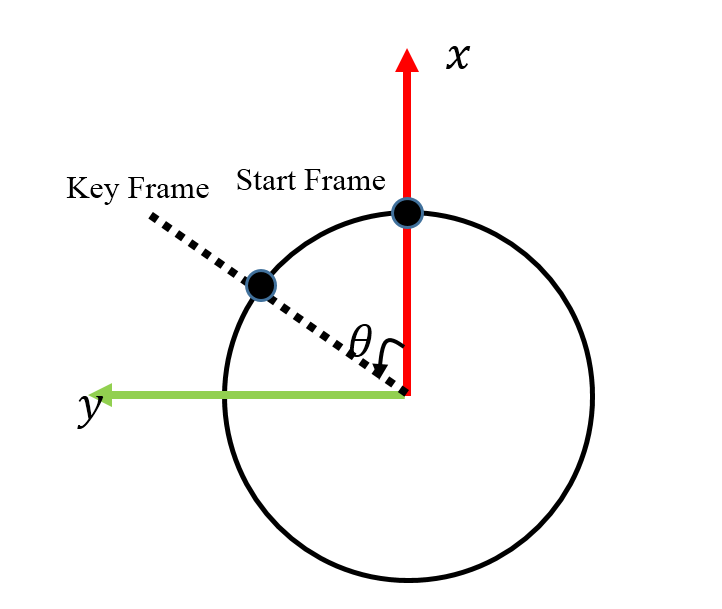

The x and y axis in the diagram above are from the world frame.

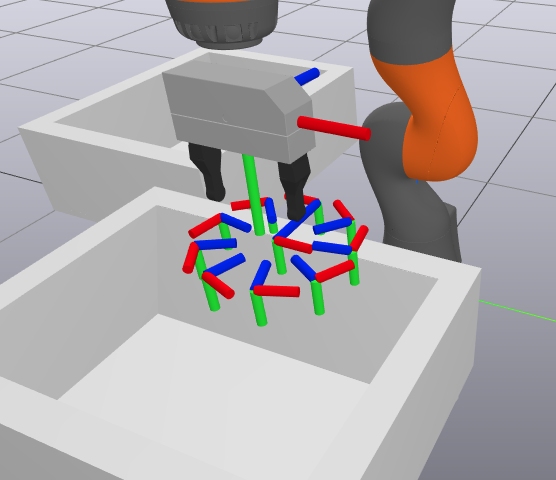

The screenshot above visualizes the key frames of the circular trajectory. The key frames illustrate the poses of the gripper in the world frame at different time steps along the trajectory. First, you should notice from the visualization above that the gripper frame is different from the world frame. In particular, the +y axis of the gripper frame points vertically downward, and the +z axis of the gripper points backward. This is an important observation for this exercise.

The rigid transform of the center of the circular trajectory as well as the radius of the circle is defined below. In words, we would like to have our arm rotate counterclockwise about the +z axis in the world frame. Besides, we would like the +z axis of the gripper frame to always point toward the center of the circle. 

In [ ]:
# define center and radius
radius = 0.1
p0 = [0.45, 0.0, 0.4]
R0 = RotationMatrix(np.array([[0, 1, 0], [0, 0, -1], [-1, 0, 0]], dtype=np.float).T)
X_WorldCenter = RigidTransform(R0, p0)

num_key_frames = 10
"""
you may use different thetas as long as your trajectory starts
from the Start Frame above and your rotation is positive
in the world frame about +z axis
thetas = np.linspace(0, 2*np.pi, num_key_frames)
"""
thetas = np.linspace(0, 2*np.pi, num_key_frames)

painter = IIWA_Painter()

We have provided an `IIWA_painter` class at the very top of this notebook to help you abstract away parts of the implementation details in Drake. You may find `visualize_transform` method helpful to visualize rigid transforms. The cell below first computes the rigid transform of the current gripper pose, and then it draws a frame of that pose in meshcat. Note that the frame drawn here is not attached to any body in the scene. They are for visualization only.

In [ ]:
X_WG = painter.get_X_WG()
painter.visualize_transform('gripper_current', X_WG)

Finally, you can compose arbitrary rotations via `MakeXRotation`, `MakeYRotation`, and `MakeZRotation` methods. Their names are quite self-explanatory.

In [ ]:
RotationMatrix.MakeYRotation(np.pi/6.0)

**Below, your job is to complete the compose_circular_key_frames method given the center of the circle and interpolated rotation angles about the center of the circle of the key frames**

In [ ]:
def compose_circular_key_frames(thetas, X_WorldCenter, X_WorldGripper_init):
    """    
    returns: a list of RigidTransforms
    """
    ## this is an template, replace your code below
    key_frame_poses_in_world = [X_WorldGripper_init]
    for theta in thetas:
        this_pose = RigidTransform()
        key_frame_poses_in_world.append(this_pose)
        
    return key_frame_poses_in_world

In [ ]:
# check key frames instead of interpolated trajectory
def visualize_key_frames(frame_poses):
    for i, pose in enumerate(frame_poses):
        painter.visualize_transform('frame_{}'.format(i), pose, length=0.05)
        
test_key_frames = compose_circular_key_frames(thetas, X_WorldCenter, painter.get_X_WG())   
visualize_key_frames(test_key_frames)

## Construct Trajectory

Now construct the trajectories to interploate the positions and orientations of key frames. You should find it helpful to review the codes in the chapter 3 colab.

**Below, your job is to construct the `PiecewisePolynomial` and `PiecewiseQuaternionSlerp` objects to store and interpolate the key frames.**

In [ ]:
from pydrake.trajectories import PiecewisePolynomial, PiecewiseQuaternionSlerp

X_WorldGripper_init = painter.get_X_WG()
test_key_frames = compose_circular_key_frames(thetas, X_WorldCenter, X_WorldGripper_init)  
times = np.linspace(0, 20, num_key_frames+1)

In [ ]:
def construct_v_w_trajectories(times, key_frames):
    """
    fill in your code here
    key_frames: a list of RigidTransforms
    """
    traj_vG = None
    traj_wG = None
    return traj_vG, traj_wG

Now you should be able to visualize the execution of the circular painting. Use it to confirm that the gripper moves counterclockwise following the key frames previously drawn in the scene.

In [ ]:
traj_v_G, traj_w_G = construct_v_w_trajectories(times, test_key_frames)
painter = IIWA_Painter(traj_v_G=traj_v_G, traj_w_G=traj_w_G)

In [ ]:
painter.paint()

**Note that in this problem we have explicitly chosen to use the initial gripper pose as the start of the circular trajectory, but is it really necessary? Explain your answer and reasoning.**
Hint: you can easily test this out using the code above

## Your Answer

Answer the question here, and copy-paste to the Gradescope 'written submission' section!

## How will this notebook be Graded?##

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `robot_painter.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [4.0 pts] `compose_circular_key_frames` is correct according to the requirement
- [2.0 pts] `construct_v_w_trajectories` is correct according to the requirement
- [2.0 pts] reasonable answer on the written question

In [ ]:
from manipulation.exercises.pick.test_robot_painter import TestRobotPainter
from manipulation.exercises.grader import Grader 

Grader.grade_output([TestRobotPainter], [locals()], 'results.json')
Grader.print_test_results('results.json')